# Deep Neural Network for MultiClass Classification

## Stage 1: We load the data and required libraries.

For this example, we use the dataset MNIST, which configures a problem of multiclass clasification (10 classes). The idea is to predict a number (0-9) form 28x28 images.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# MNIST dataset is available in pytorch

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:23<00:00, 429kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 278kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 731kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 987kB/s]


In [3]:
# Showing some examples
img, label = training_data[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 5


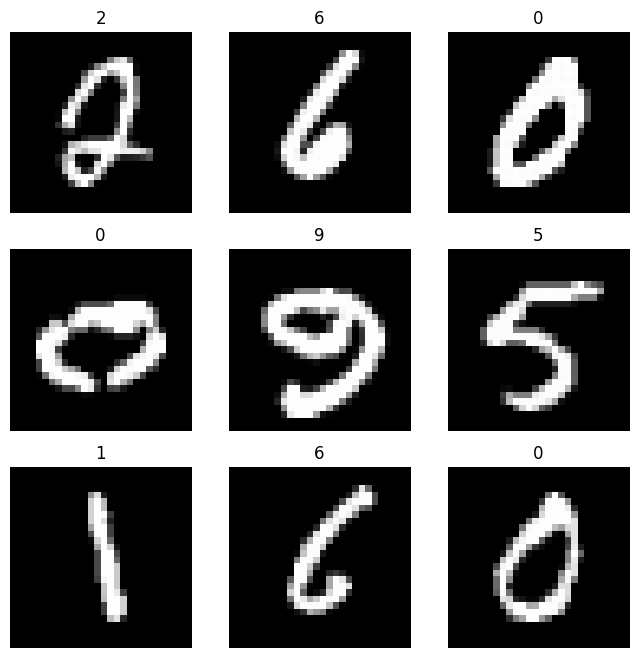

In [5]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
# We define an object to load the data
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Stage 2: Deep Neural Network definiton.

In [7]:
# We do this to use the GPU (if we only use CPU, the training will take a lot of time)
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

mps


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Originally, the inputs were 28x28 images;
        # however, the fully connected networks cannot handle images. Hence, we
        # perform an initial operation called flatten to convert the images into
        # vectors. For example, since we have 28x28 images, the resultant vector
        # will have a dimension of 28*28=784.
        # See https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32), # The input layer has 28*28 units.
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10), # Note that the output layer has 10 units, Also
            # notice that we don't use any activation. This is because the loss
            # function computes the Softmax function internally.
        )

    def forward(self, x):
        # This method is used to compute the output given a particular input x.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
# WE can verify the built network
model = NeuralNetwork()
model.to(device) # This is to define the model in the GPU
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [13]:
# WE define the hyperparameters and the loss function
learning_rate = 0.05
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
# The optimization loop.

loss_tr = []
loss_te = []
for epoch in range(epochs):
  for x, y in train_dataloader:
    # The variable should be sent to the GPU
    x = x.to(device)
    y = y.to(device)
    # Make predictions
    model.train()
    y_pred = model(x)
    # Compute the loss of current predictions
    loss = loss_fn(y_pred, y)
    # Clean the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # update weights
    optimizer.step()
    # Storing the training and test losses
    loss_tr.append(loss.item())
    loss_test = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        loss_test += loss_fn(outputs, labels).item() * labels.size(0)

  loss_te.append(loss_test/len(test_dataloader.dataset))
  print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test/len(test_dataloader.dataset)))

epoch 1 loss: 0.2887 test_loss: 0.3370
epoch 2 loss: 0.0702 test_loss: 0.2846
epoch 3 loss: 0.3040 test_loss: 0.2234
epoch 4 loss: 0.1781 test_loss: 0.1813
epoch 5 loss: 0.0843 test_loss: 0.1644
epoch 6 loss: 0.1508 test_loss: 0.1578
epoch 7 loss: 0.0490 test_loss: 0.1352
epoch 8 loss: 0.2463 test_loss: 0.1321
epoch 9 loss: 0.0520 test_loss: 0.1314
epoch 10 loss: 0.0470 test_loss: 0.1216
epoch 11 loss: 0.1822 test_loss: 0.1208
epoch 12 loss: 0.2996 test_loss: 0.1226
epoch 13 loss: 0.0474 test_loss: 0.1137
epoch 14 loss: 0.0410 test_loss: 0.1040
epoch 15 loss: 0.0464 test_loss: 0.1053
epoch 16 loss: 0.0141 test_loss: 0.1041
epoch 17 loss: 0.0167 test_loss: 0.1061
epoch 18 loss: 0.0219 test_loss: 0.1074
epoch 19 loss: 0.0455 test_loss: 0.1215
epoch 20 loss: 0.0095 test_loss: 0.1025


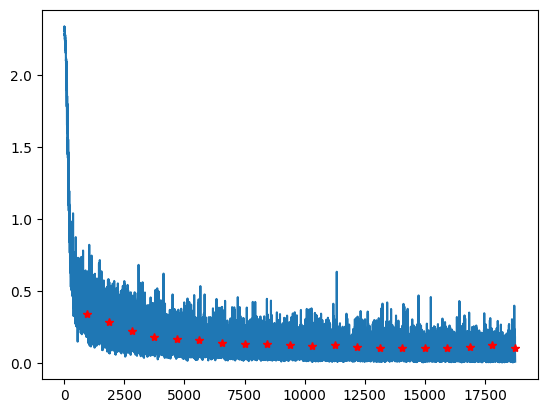

In [15]:
# Plot the losses for the train and test sets
import numpy as np
plt.plot(loss_tr)
plt.plot(np.arange(1,21)*len(train_dataloader.dataset)//64,loss_te, 'r*')
plt.show()

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %
